# Backtesting

This notebook generates plots for the [paper/](paper/) directory. This assumes you've alread run
```sh
make update                       # Downloads and preprocesses data.
source run_backtesting.sh         # Runs backtesting experiments
```
Note that `make update` takes a couple hours the first time it is run (mostly in sequence alignment), and `mutrans.py` takes about 15 minutes on a GPU (will take much longer if no GPU is available).

In [1]:
import datetime
import math
import os
import pickle
import re
import logging
from collections import Counter, OrderedDict, defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pyro.distributions as dist
from pyrocov import mutrans, pangolin, stats
from pyrocov.stats import normal_log10bf
from pyrocov.util import pretty_print, pearson_correlation

In [2]:
# configure logging
logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

In [3]:
# For changing log level as required
logging.getLogger().setLevel(logging.INFO)

In [4]:
# set matplotlib params
matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams['figure.figsize'] = [8, 8]
matplotlib.rcParams["axes.edgecolor"] = "gray"
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Avenir', 'DejaVu Sans']

## Load data

In [5]:
with open("results/gisaid.columns.pkl", "rb") as f:
    columns = pickle.load(f)
print("Loaded data from {} samples".format(len(columns["lineage"])))

Loaded data from 2161248 samples


In [6]:
type(columns)

dict

In [7]:
columns.keys()

dict_keys(['lineage', 'virus_name', 'accession_id', 'collection_date', 'location', 'add_location', 'day'])

In [8]:
for k in columns.keys():
    print(k, columns[k][0:2])

lineage ['B.1', 'B.1']
virus_name ['hCoV-19/Australia/NT12/2020', 'hCoV-19/Australia/NT13/2020']
accession_id ['EPI_ISL_426900', 'EPI_ISL_426901']
collection_date ['2020-03-25', '2020-03-25']
location ['Oceania / Australia / Northern Territory', 'Oceania / Australia / Northern Territory']
add_location ['', '']
day [115, 115]


Sanity checking case count time series:

In [9]:
if False:
    plt.figure(figsize=(8, 3))
    plt.plot(weekly_cases, lw=1, alpha=0.5)
    plt.yscale("symlog", linthresh=10)
    plt.ylim(0, None)
    plt.xlim(0, len(weekly_cases) - 1)
    plt.xlabel("week after 2019-12-01")
    plt.ylabel("confirmed cases");

    plt.figure(figsize=(8, 3))
    plt.plot(weekly_strains.sum(-1), lw=1, alpha=0.5)
    plt.yscale("symlog", linthresh=10)
    plt.ylim(0, None)
    plt.xlim(0, len(weekly_cases) - 1)
    plt.xlabel("week after 2019-12-01")
    plt.ylabel("sequenced samples");

In [10]:
# locations = set(location_id)
# N_usa = sum(1 for k in locations if "/ USA /" in k)
# N_uk = sum(1 for k in locations if "/ United Kingdom /" in k)
# N_other = len(locations) - N_usa - N_uk
# print(N_usa, N_uk, N_other)

We'll account for epidemiological dynamics in the form of random drift on top of our logistic growth model. Since random drift is inversely proportional to the local number of infections, we'll need a new data source for the number of infections in each region. We'll use JHU's confirmed case counts time series as a proxy for the number of total infections in each region.

## Load trained models

In [13]:
fits = torch.load("results/mutrans.pt", map_location="cpu")

In [14]:
# print info on available models and what the keys are
for key in fits:
    print(key)
first_key = list(fits.keys())[0]
fits[first_key].keys()

('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 150, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 164, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 178, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 192, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 206, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 220, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 234, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 248, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 262, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 276, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 290, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 304, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 318, ())
('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 332, ())
('coef

dict_keys(['median', 'mean', 'std', 'losses', 'series', 'params', 'walltime', 'args', 'mutations', 'weekly_strains', 'weekly_cases', 'weekly_strains_shape', 'location_id', 'lineage_id_inv'])

In [15]:
# Print the shape of the weekly strains in each fit
for fit in fits.values():
    print(fit["weekly_strains_shape"])

(11, 592, 1281)
(12, 612, 1281)
(13, 626, 1281)
(14, 645, 1281)
(15, 665, 1281)
(16, 681, 1281)
(17, 692, 1281)
(18, 715, 1281)
(19, 730, 1281)
(20, 738, 1281)
(21, 751, 1281)
(22, 759, 1281)
(23, 774, 1281)
(24, 783, 1281)
(25, 799, 1281)
(26, 809, 1281)
(27, 820, 1281)
(28, 842, 1281)
(29, 871, 1281)
(30, 908, 1281)
(31, 948, 1281)
(32, 981, 1281)
(33, 1012, 1281)
(34, 1033, 1281)
(35, 1045, 1281)
(36, 1057, 1281)
(37, 1059, 1281)
(38, 1065, 1281)
(39, 1069, 1281)


In [16]:
# This is really just the second fit
selected_fit = list(fits.values())[1]
#pretty_print(selected_fit, max_items=40)

Scale `coef` by 1/100 in all results.

In [17]:
ALREADY_SCALED = set()

def scale_tensors(x, names={"coef"}, scale=0.01, prefix=""):
    if id(x) in ALREADY_SCALED:
        return
    if isinstance(x, dict):
        for k, v in list(x.items()):
            if k in names:
                print(f"{prefix}.{k}")
                x[k] = v * scale
            elif k == "diagnostics":
                continue
            else:
                scale_tensors(v, names, scale, f"{prefix}.{k}")
    ALREADY_SCALED.add(id(x))
                
scale_tensors(fits)

.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 150, ()).median.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 150, ()).mean.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 150, ()).std.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 164, ()).median.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 164, ()).mean.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 164, ()).std.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 178, ()).median.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 178, ()).mean.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 178, ()).std.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 192, ()).median.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 192, ()).mean.coef
.('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 192, ()).std.coef
.('coef_scal

In [18]:
# plt.figure(figsize=(2,2))
# plt.hist(selected_fit["params"]["local_time"].reshape(-1).numpy(), bins=50, density=True)
# plt.xlabel("local time shift");

## Forecasting

In [19]:
import importlib
from pyrocov import mutrans_helpers

In [20]:
# Reload the import library helpers
importlib.reload(mutrans_helpers)

<module 'pyrocov.mutrans_helpers' from '/home/nbarkas/pyro-cov/pyro-cov/pyrocov/mutrans_helpers.py'>

In [21]:
# customize logging
logging.getLogger().setLevel(logging.ERROR)

## Last model (for comparison)

In [22]:
logging.getLogger().setLevel(logging.INFO)

Max days of model: 542


   115832 Generating output tensor
   115900 --- Processing query 0


sel_forecast shape torch.Size([51, 1281])
sel_forecast_lb shape torch.Size([51, 1281])


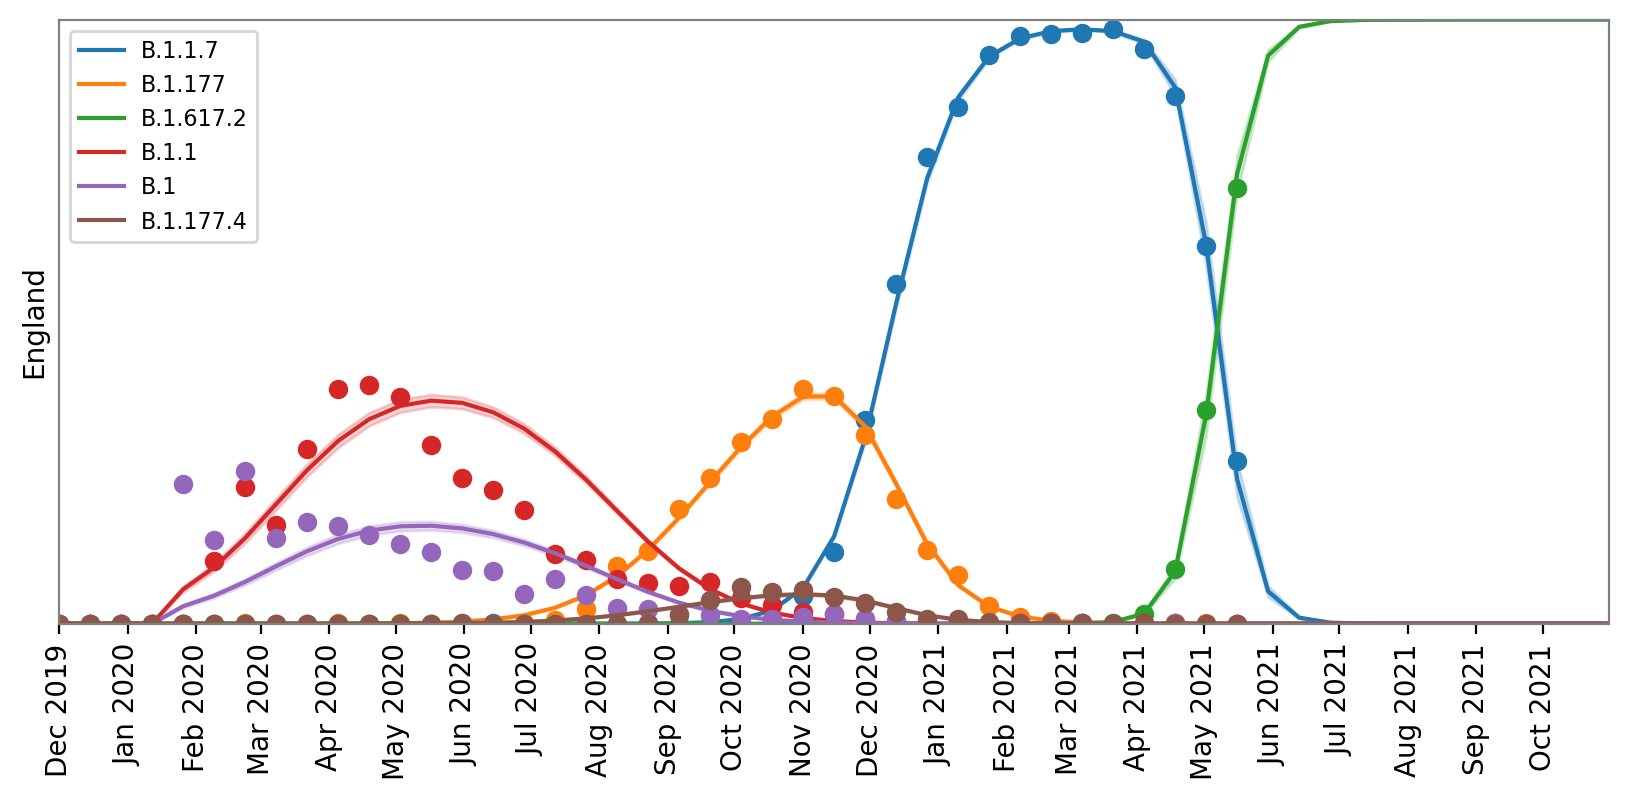

In [23]:
importlib.reload(mutrans_helpers)

i = len(fits) - 1
key, latest_fit = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1',
                                 'B.1.1','B.1','B.1.427','B.1.2','B.1.177.4']

matplotlib.rcParams['figure.figsize'] = [10, 4]
mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit, 
    strains_to_show=strains_from_manuscript_figure,queries=['England']
)

# Forecasts at the point where B.1.1.7 arises in the UK

## Day 346

   328543 Generating output tensor
   328544 --- Processing query 0


Max days of model: 346
sel_forecast shape torch.Size([37, 1281])
sel_forecast_lb shape torch.Size([37, 1281])


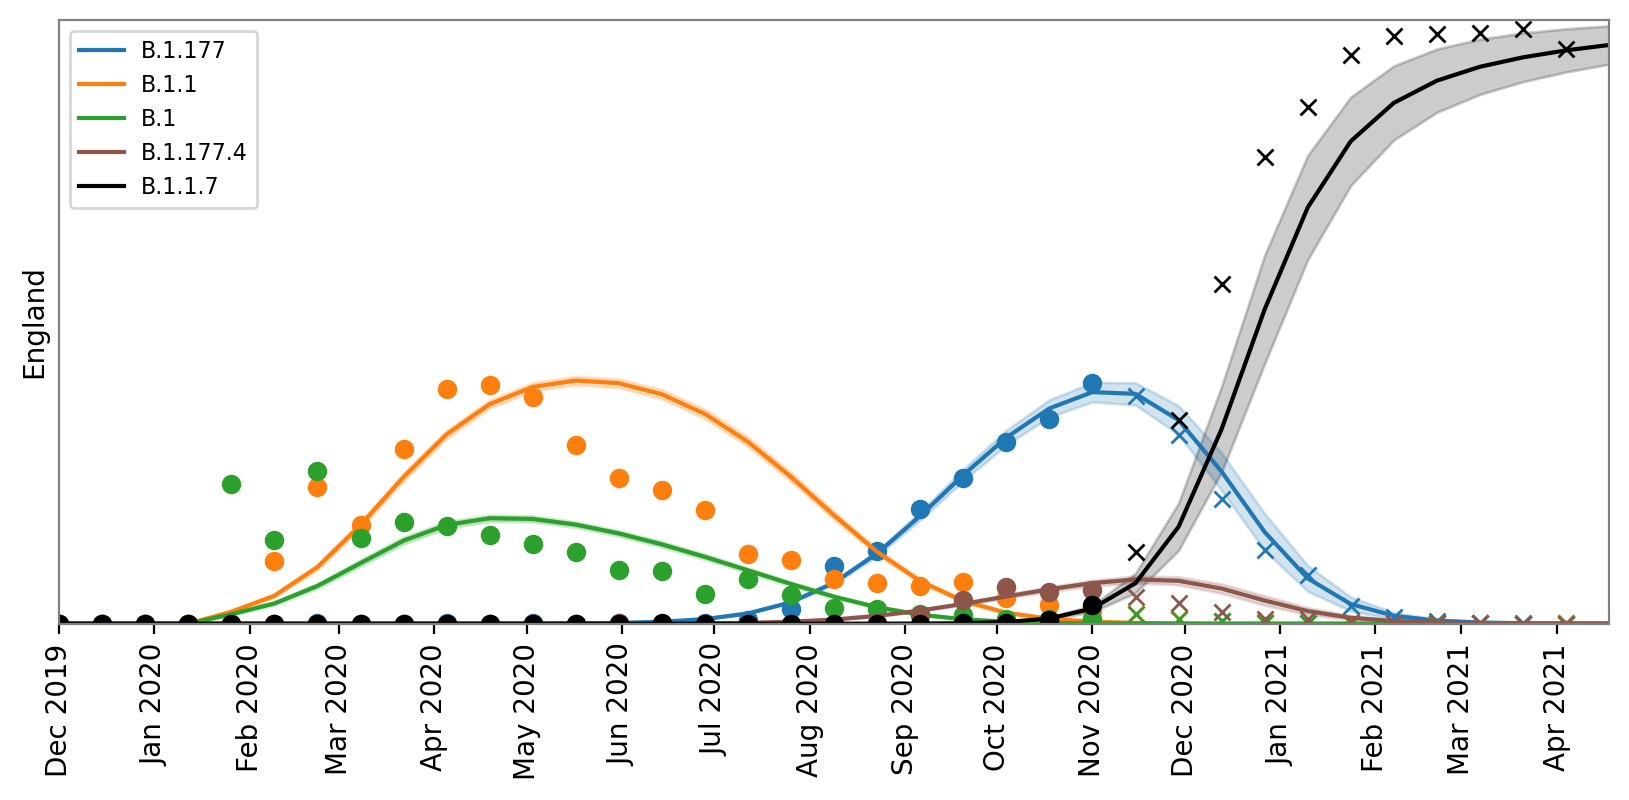

In [33]:
importlib.reload(mutrans_helpers)

i = 14
key, fit_d346 = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1',
                                 'B.1.1','B.1','B.1.427','B.1.2','B.1.177.4']

matplotlib.rcParams['figure.figsize'] = [10, 4]
mutrans_helpers.plot_fit_forecasts(
    fit=fit_d346, 
    strains_to_show=strains_from_manuscript_figure,queries=['England'],num_strains=1000,
        future_fit=latest_fit,
    filename='paper/forecasts/forecast_day_325.png',
)

In [34]:
importlib.reload(mutrans_helpers)

<module 'pyrocov.mutrans_helpers' from '/home/nbarkas/pyro-cov/pyro-cov/pyrocov/mutrans_helpers.py'>

In [35]:
q = {"England": ['B.1','B.1.1.7','B.1.177','B.1.177.4']}

mutrans_helpers.evaluate_fit_forecast(fit_d346, latest_fit, 
                                      queries = q)

{'England MAE': tensor(15.2572),
 'England RMSE': tensor(527.5945),
 'England B.1 MAE': tensor(34.1670),
 'England B.1 RMSE': tensor([53.0379]),
 'England B.1.1.7 MAE': tensor(16554.6562),
 'England B.1.1.7 RMSE': tensor([18780.6680]),
 'England B.1.177 MAE': tensor(1300.5624),
 'England B.1.177 RMSE': tensor([1898.8243]),
 'England B.1.177.4 MAE': tensor(128.8104),
 'England B.1.177.4 RMSE': tensor([192.5791])}

## Day 262

   346558 Generating output tensor
   346559 --- Processing query 0


Max days of model: 262
sel_forecast shape torch.Size([31, 1281])
sel_forecast_lb shape torch.Size([31, 1281])


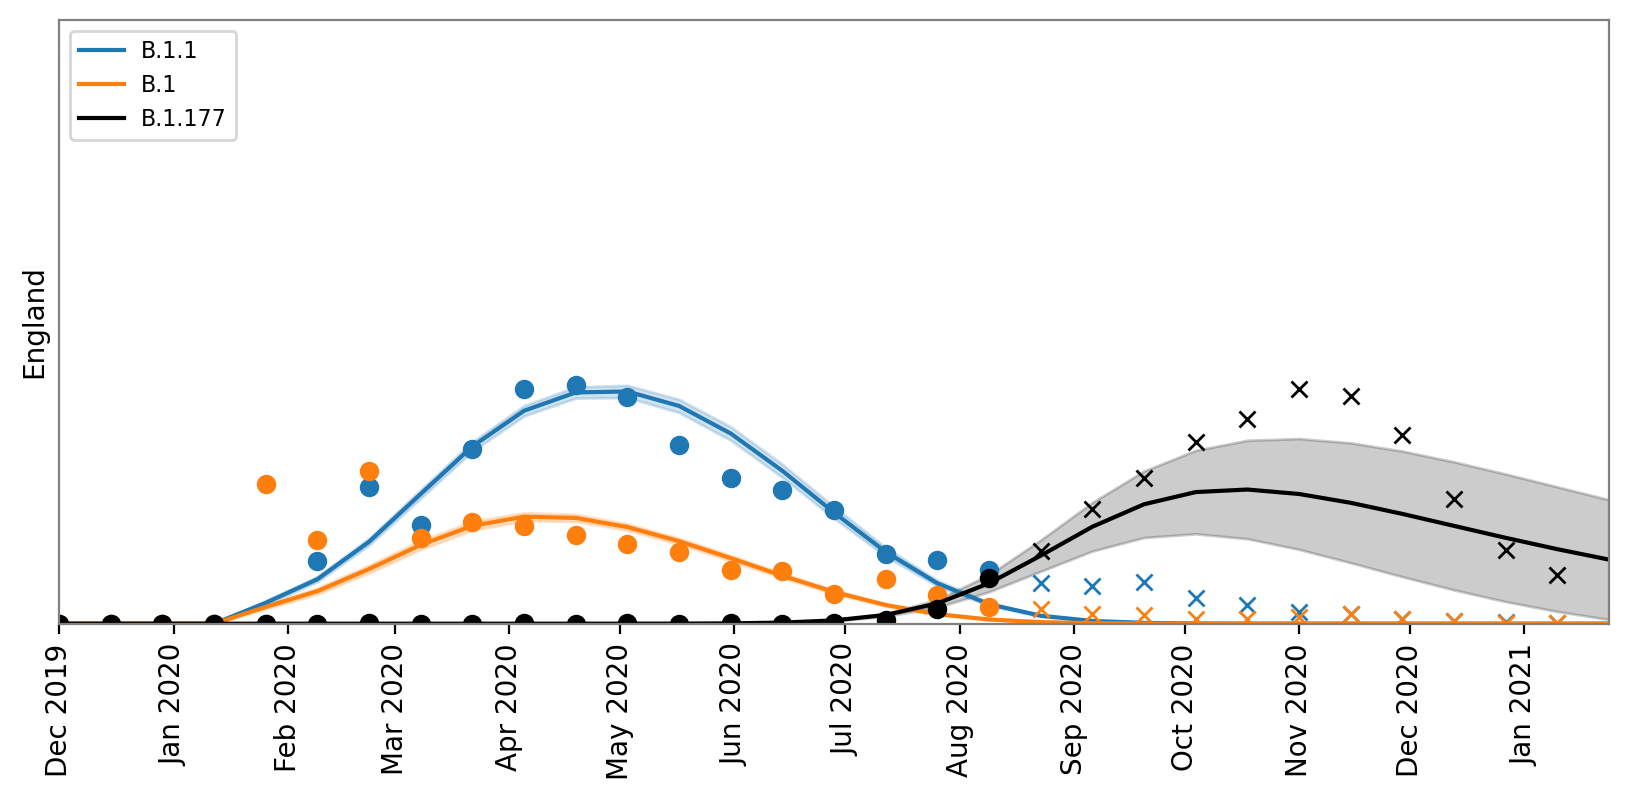

In [36]:
importlib.reload(mutrans_helpers)

#i = 9
i = 8
key, fit_d262 = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1',
                                 'B.1.1','B.1','B.1.427','B.1.2','B.1.177.4']

matplotlib.rcParams['figure.figsize'] = [10, 4]
mutrans_helpers.plot_fit_forecasts(
    fit=fit_d262, 
    strains_to_show=strains_from_manuscript_figure,queries=['England'],
        future_fit=latest_fit,
     filename='paper/forecasts/forecast_day_350.png'
)

In [37]:
q = {"England": ['B.1','B.1.1.7','B.1.177','B.1.177.4']}

mutrans_helpers.evaluate_fit_forecast(fit_d262, latest_fit, 
                                      queries = q)

{'England MAE': tensor(10.8802),
 'England RMSE': tensor(332.0190),
 'England B.1 MAE': tensor(85.5001),
 'England B.1 RMSE': tensor([98.2268]),
 'England B.1.1.7 MAE': tensor(6552.6665),
 'England B.1.1.7 RMSE': tensor([11377.1953]),
 'England B.1.177 MAE': tensor(2753.6589),
 'England B.1.177 RMSE': tensor([3283.8398]),
 'England B.1.177.4 MAE': tensor(349.7504),
 'England B.1.177.4 RMSE': tensor([454.2886])}

# Day 276

   469908 Generating output tensor
   469909 --- Processing query 0


Max days of model: 276
sel_forecast shape torch.Size([32, 1281])
sel_forecast_lb shape torch.Size([32, 1281])


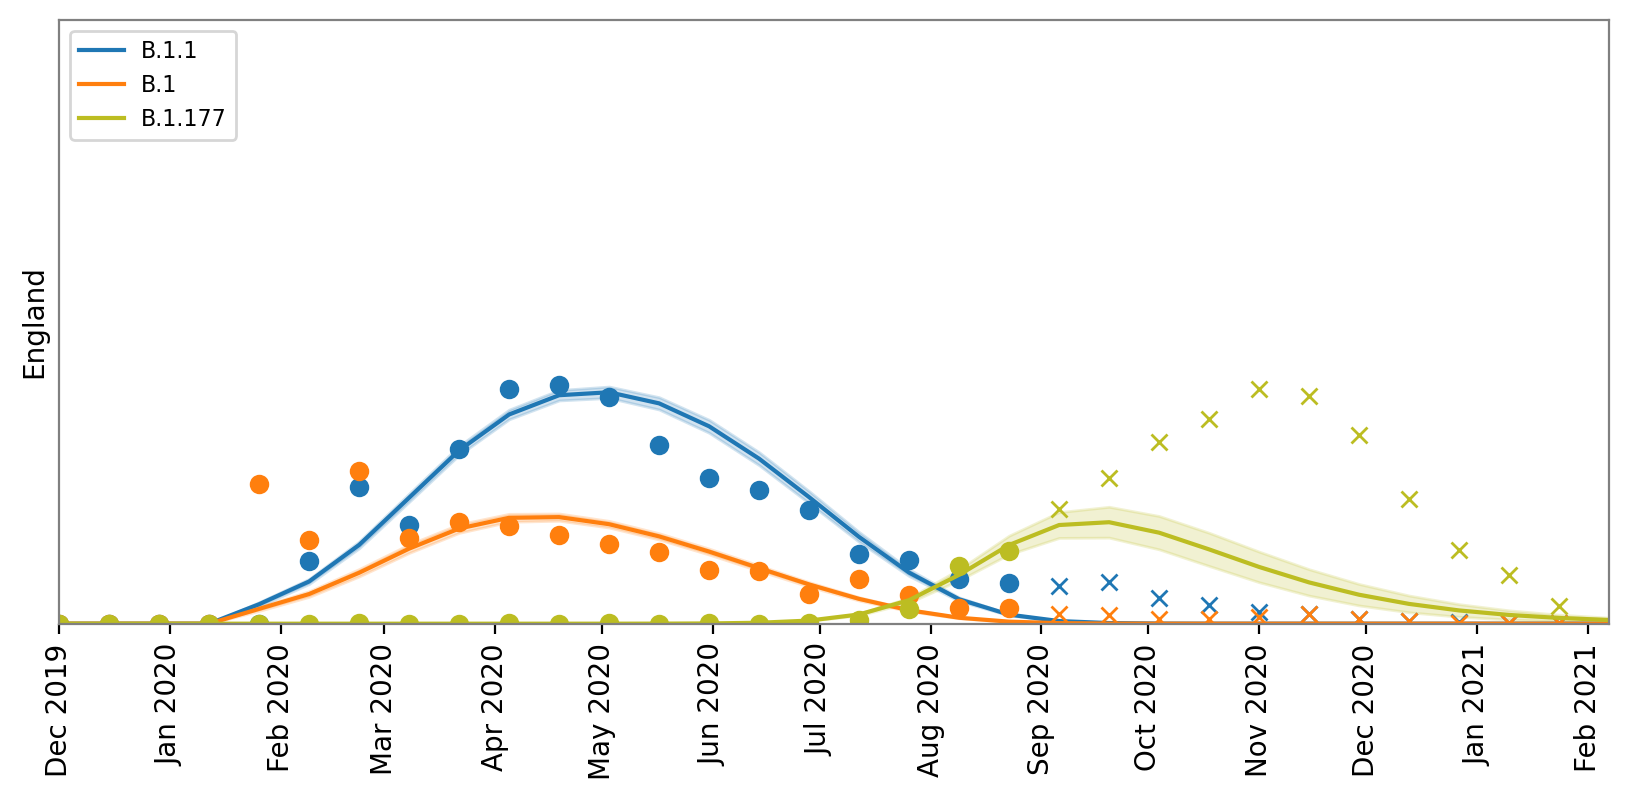

In [44]:
importlib.reload(mutrans_helpers)

#i = 9
i = 9
key, fit_d276 = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1',
                                 'B.1.1','B.1','B.1.427','B.1.2','B.1.177.4']

matplotlib.rcParams['figure.figsize'] = [10, 4]
mutrans_helpers.plot_fit_forecasts(
    fit=fit_d276, 
    strains_to_show=strains_from_manuscript_figure,
    queries=['England'],
    future_fit=latest_fit,
    filename='paper/forecasts/forecast_day_375.png'
)

In [45]:
q = {"England": ['B.1','B.1.1.7','B.1.177','B.1.177.4']}

mutrans_helpers.evaluate_fit_forecast(fit_d276, latest_fit, 
                                      queries = q)

{'England MAE': tensor(12.3166),
 'England RMSE': tensor(389.0138),
 'England B.1 MAE': tensor(78.9169),
 'England B.1 RMSE': tensor([94.8514]),
 'England B.1.1.7 MAE': tensor(8648.0830),
 'England B.1.1.7 RMSE': tensor([13495.5488]),
 'England B.1.177 MAE': tensor(2738.6755),
 'England B.1.177 RMSE': tensor([3282.2593]),
 'England B.1.177.4 MAE': tensor(352.5837),
 'England B.1.177.4 RMSE': tensor([454.4071])}

   549308 Generating output tensor
   549310 --- Processing query 0


Max days of model: 220
sel_forecast shape torch.Size([28, 1281])
sel_forecast_lb shape torch.Size([28, 1281])


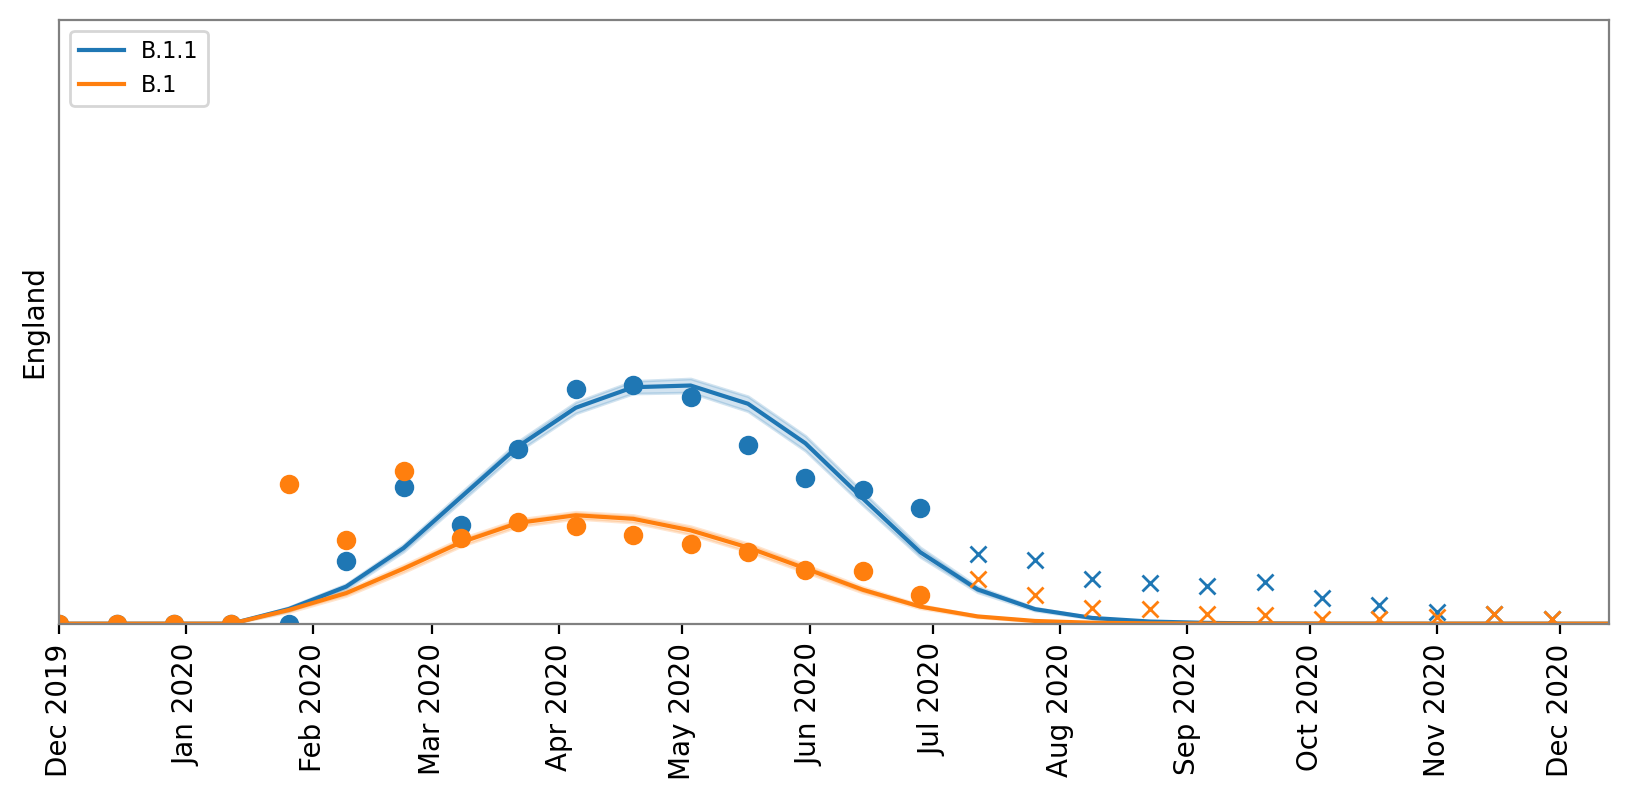

In [47]:
## Timepoint wher B.1.177 arises
importlib.reload(mutrans_helpers)

i = 5
key, fit_d220 = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1',
                                 'B.1.1','B.1','B.1.427','B.1.2','B.1.177.4']

matplotlib.rcParams['figure.figsize'] = [10, 4]
mutrans_helpers.plot_fit_forecasts(
    fit=fit_d220, 
    strains_to_show=strains_from_manuscript_figure,
    queries=['England'],
    future_fit=latest_fit,
    filename='paper/forecasts/forecast_day_275.png'
)

In [49]:
q = {"England": ['B.1','B.1.1','B.1.1.7','B.1.177','B.1.177.4']}

mutrans_helpers.evaluate_fit_forecast(fit_d220, latest_fit, 
                                      queries = q)

{'England MAE': tensor(6.3265),
 'England RMSE': tensor(119.5204),
 'England B.1 MAE': tensor(94.9154),
 'England B.1 RMSE': tensor([103.2476]),
 'England B.1.1 MAE': tensor(248.5756),
 'England B.1.1 RMSE': tensor([288.5120]),
 'England B.1.1.7 MAE': tensor(1168.1670),
 'England B.1.1.7 RMSE': tensor([2726.8936]),
 'England B.1.177 MAE': tensor(2327.0837),
 'England B.1.177 RMSE': tensor([3142.9915]),
 'England B.1.177.4 MAE': tensor(312.5837),
 'England B.1.177.4 RMSE': tensor([447.6896])}

# Day 234

   722524 Generating output tensor
   722525 --- Processing query 0


Max days of model: 234
sel_forecast shape torch.Size([29, 1281])
sel_forecast_lb shape torch.Size([29, 1281])


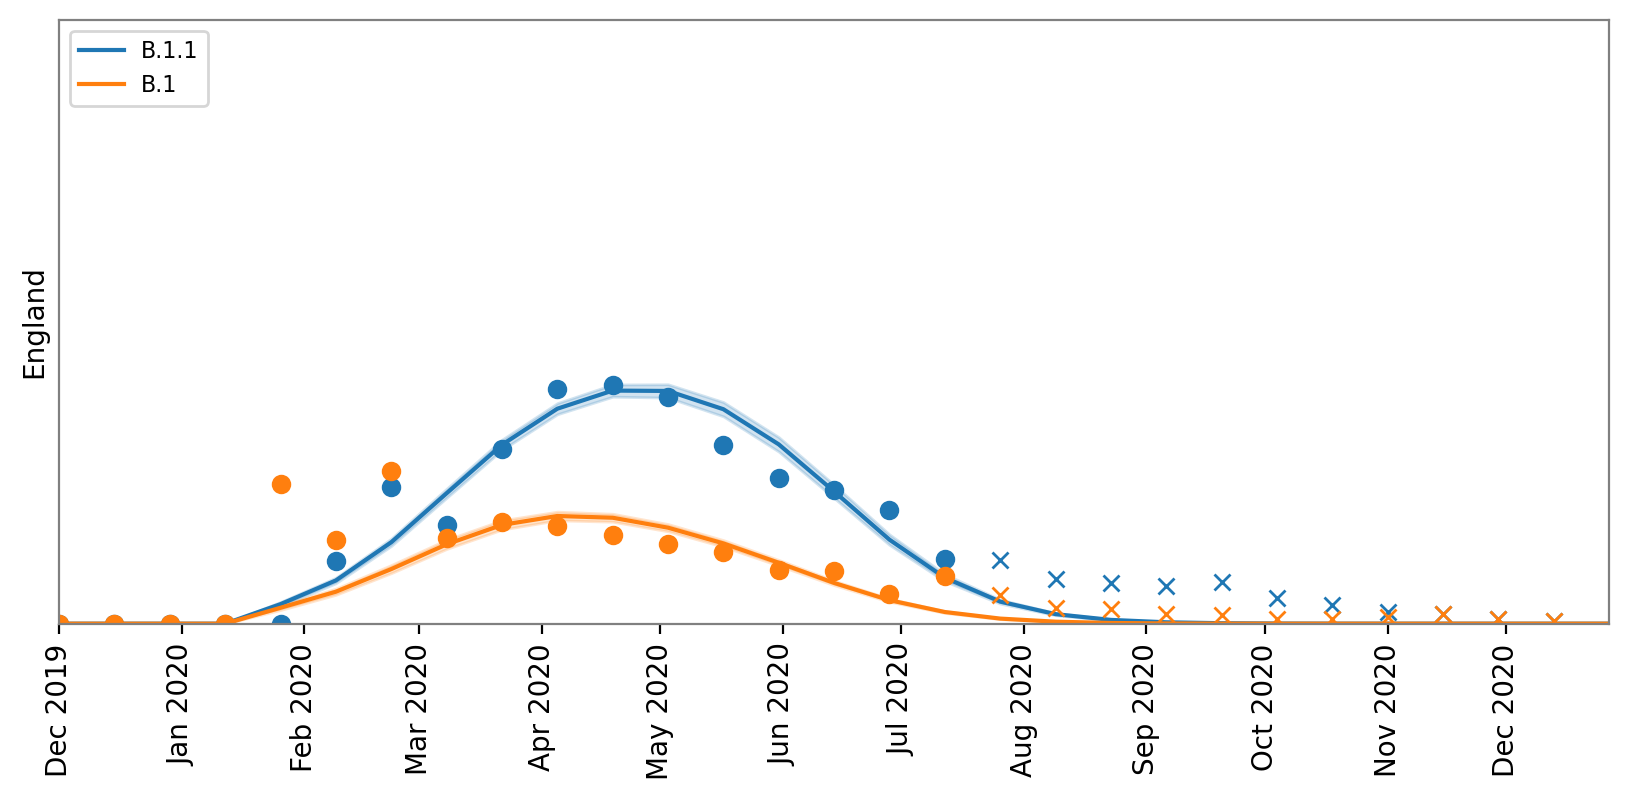

In [53]:
importlib.reload(mutrans_helpers)

i = 6
key, fit_d234 = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1',
                                 'B.1.1','B.1','B.1.427','B.1.2','B.1.177.4']

matplotlib.rcParams['figure.figsize'] = [10, 4]
mutrans_helpers.plot_fit_forecasts(
    fit=fit, 
    strains_to_show=strains_from_manuscript_figure,
    queries=['England'],
    future_fit=latest_fit,
     filename='paper/forecasts/forecast_day_300.png'
)

In [54]:
q = {"England": ['B.1','B.1.1','B.1.1.7','B.1.177','B.1.177.4']}

mutrans_helpers.evaluate_fit_forecast(fit_d234, latest_fit, 
                                      queries = q)

{'England MAE': tensor(7.4959),
 'England RMSE': tensor(170.7194),
 'England B.1 MAE': tensor(89.9159),
 'England B.1 RMSE': tensor([99.9510]),
 'England B.1.1 MAE': tensor(239.0784),
 'England B.1.1 RMSE': tensor([285.3681]),
 'England B.1.1.7 MAE': tensor(2412.0837),
 'England B.1.1.7 RMSE': tensor([5099.4014]),
 'England B.1.177 MAE': tensor(2523.0835),
 'England B.1.177 RMSE': tensor([3215.9792]),
 'England B.1.177.4 MAE': tensor(324.6671),
 'England B.1.177.4 RMSE': tensor([449.6422])}

In [56]:
# Day 248

   763341 Generating output tensor
   763342 --- Processing query 0


Max days of model: 248
sel_forecast shape torch.Size([30, 1281])
sel_forecast_lb shape torch.Size([30, 1281])


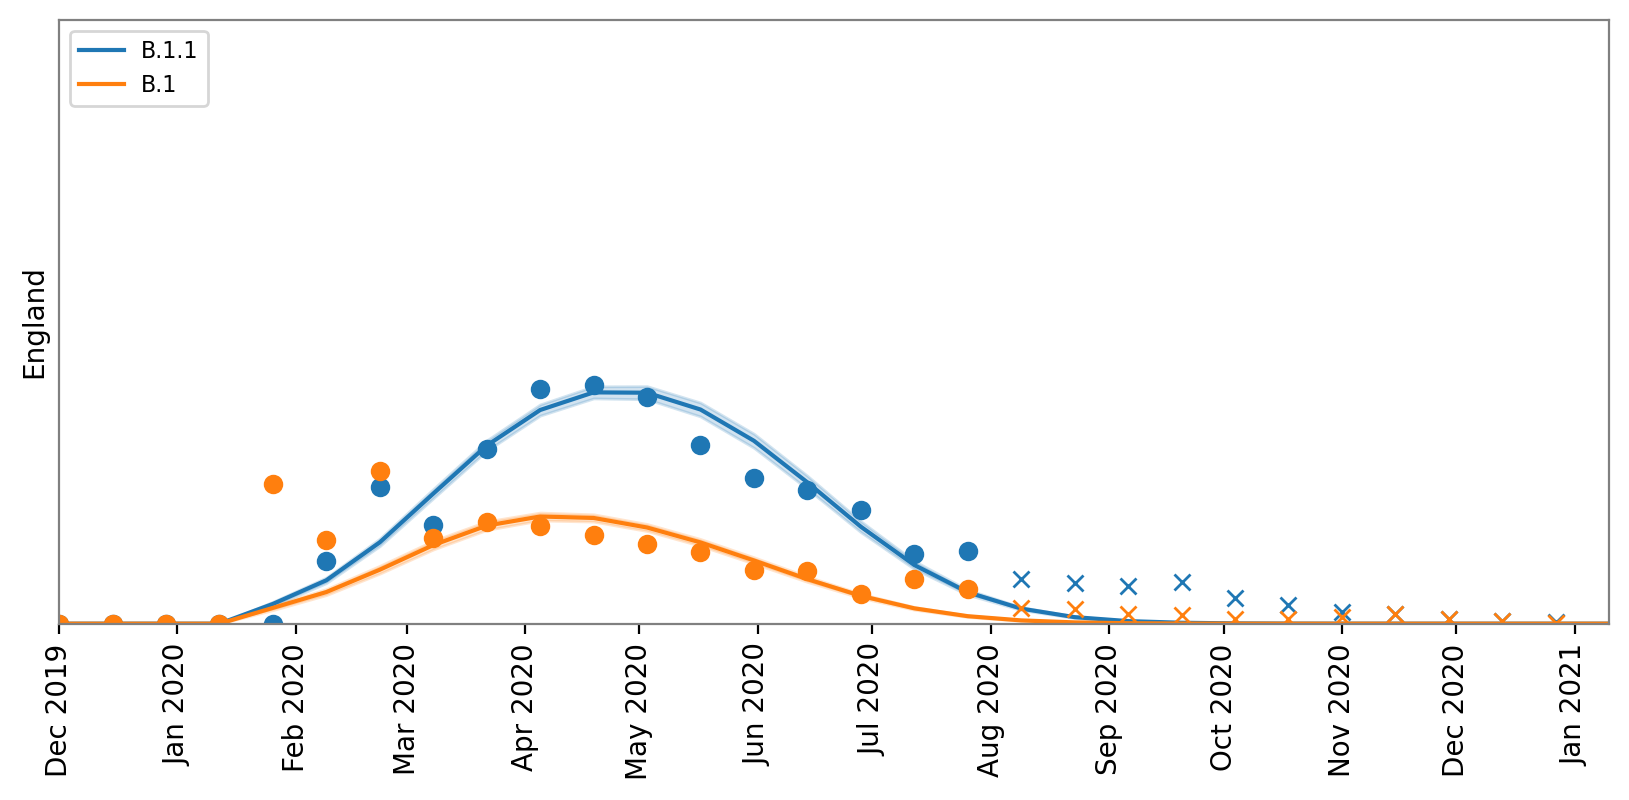

In [59]:
importlib.reload(mutrans_helpers)

i = 7
key, fit_d248 = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1',
                                 'B.1.1','B.1','B.1.427','B.1.2','B.1.177.4']

matplotlib.rcParams['figure.figsize'] = [10, 4]
mutrans_helpers.plot_fit_forecasts(
    fit=fit_d248, 
    strains_to_show=strains_from_manuscript_figure,
    queries=['England'],
    future_fit=latest_fit,
    filename='paper/forecasts/forecast_day_325.png'
    
)

In [60]:
q = {"England": ['B.1','B.1.1','B.1.1.7','B.1.177','B.1.177.4']}

mutrans_helpers.evaluate_fit_forecast(fit_d234, latest_fit, 
                                      queries = q)

{'England MAE': tensor(7.4959),
 'England RMSE': tensor(170.7194),
 'England B.1 MAE': tensor(89.9159),
 'England B.1 RMSE': tensor([99.9510]),
 'England B.1.1 MAE': tensor(239.0784),
 'England B.1.1 RMSE': tensor([285.3681]),
 'England B.1.1.7 MAE': tensor(2412.0837),
 'England B.1.1.7 RMSE': tensor([5099.4014]),
 'England B.1.177 MAE': tensor(2523.0835),
 'England B.1.177 RMSE': tensor([3215.9792]),
 'England B.1.177.4 MAE': tensor(324.6671),
 'England B.1.177.4 RMSE': tensor([449.6422])}

In [63]:
# day 262

   810576 Generating output tensor
   810577 --- Processing query 0


Max days of model: 262
sel_forecast shape torch.Size([31, 1281])
sel_forecast_lb shape torch.Size([31, 1281])


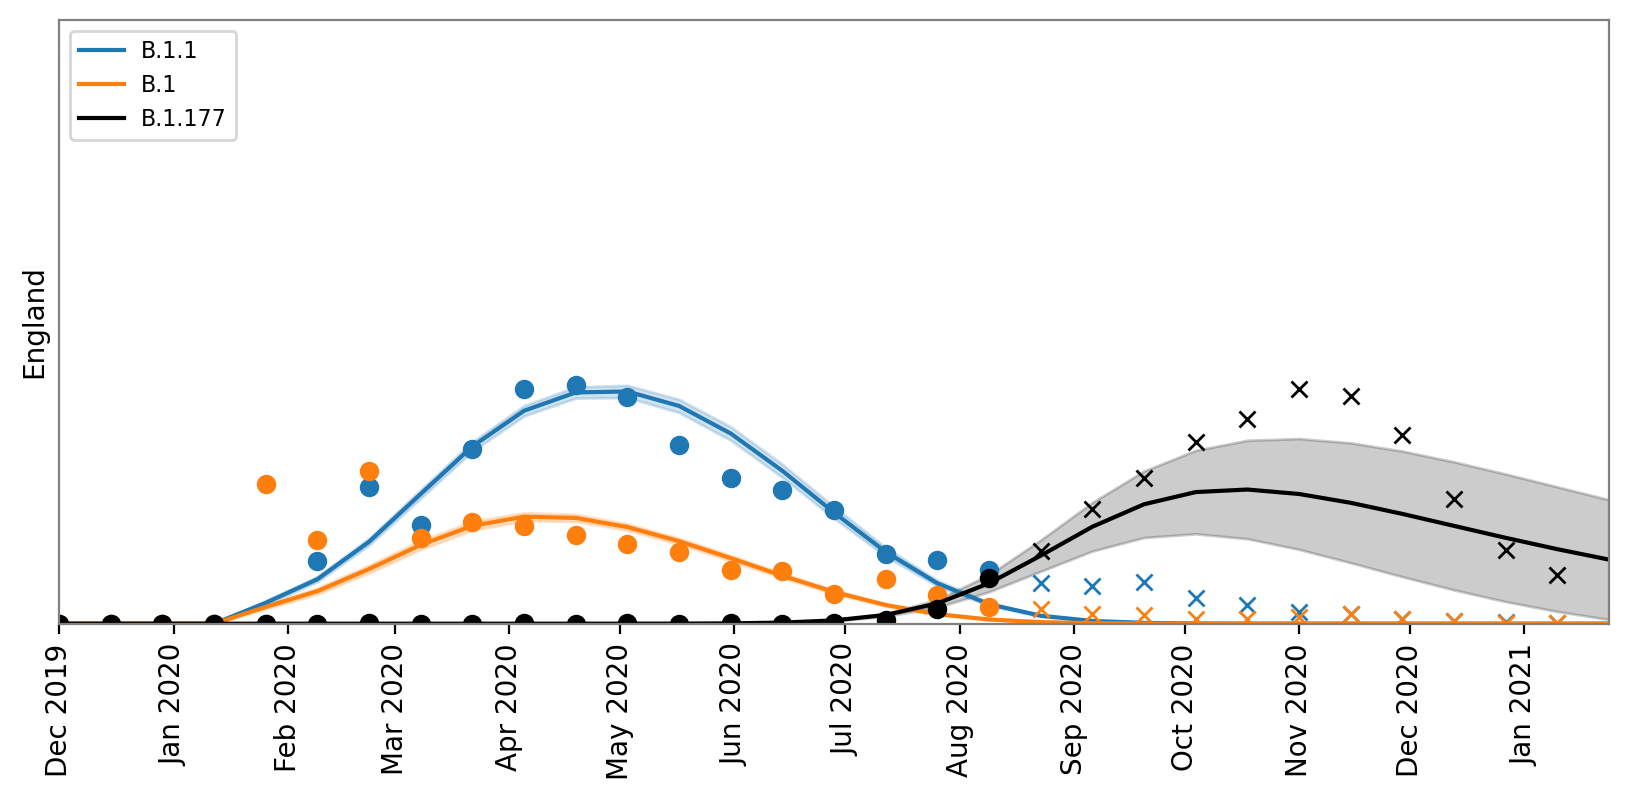

In [65]:
i = 8
key, fit_d262 = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1',
                                 'B.1.1','B.1','B.1.427','B.1.2','B.1.177.4']

matplotlib.rcParams['figure.figsize'] = [10, 4]
mutrans_helpers.plot_fit_forecasts(
    fit=fit, 
    strains_to_show=strains_from_manuscript_figure,
    queries=['England'],
    future_fit=latest_fit,
    filename='paper/forecasts/forecast_day_350.png'
)

In [67]:
importlib.reload(mutrans_helpers)
res = mutrans_helpers.evaluate_fit_forecast(fit_d262, latest_fit)
res

{'England MAE': tensor(10.8802),
 'England RMSE': tensor(332.0190),
 'England B.1.1.7 MAE': tensor(6552.6665),
 'England B.1.1.7 RMSE': tensor([11377.1953])}

In [ ]:
[p for p in latest_fit['location_id']]

In [ ]:
latest_fit['location_id']

In [ ]:
fit['location_id']